# What is a match?
# Labelling the data

# What is match?

The computer can calculate the distance between two records. But only you can tell if the two records should be linked together, or if they are se
parate. This is called labelling the data.     
     
Essentially, whether two records are one and the same depends on your model and your use case. If I am looking to merge two list of companies:
- for logistic purposes (i.e. delivery of supplies, for example), I would like to merge all sites that share exactly the same address and roughly the same name.
- for strategic purposes (i.e. what is the overall number of sites of a big conglomerate),I am  more focussed on the name and legal number.
- for tax and legal purposes, I am less interested in the exact address, but more on the legal register number, the tax or VAT number.

Once you have a clear purpose and model in the mind, you can now answer the questions to tell if they are a match or not

## Set-up of the score matrix

We will continue with our dataset of companies. We will be comparing the two datasets together, by applying the comparators seen in the previous chapters to the different fields of the data

### Data imports

In [1]:
import pandas as pd
from suricate.data.companies import getXst
Xst = getXst(nrows=200)
source = Xst[0]
target = Xst[1]

### Let's display the 'source' dataframe

In [2]:
source.sample(5)

,name,street,city,postalcode,duns,countrycode
ix,,,,,,
b60f09c2,stc steyr wlzlager,40 41 rosenthaler str,berlin,10178,NaN,DE
9438b5e4,dichtelemente arcus gmbh,6 gromoor ring,hamburg,21079,313821894.0,DE
f21848af,united parcel service,garlitzer str,neuss,41401,NaN,DE
4389becc,ask distribution,rue de la boucherie,molsheim,67120,NaN,FR
e6950a84,temai ingenieros,10 calle de rivas,coslada,28821,NaN,ES


## 1. Creating the similarity matrix
We can pipeline and concatenate several comparators using standard scikit-learn operators.
For each pair of record between the source and target dataframe, we have created 8 different scores measuring the distance between the different columns. In order to reduce the noise and the correlation between the columns, it is usually good practice to scale the data and then to reduce the number of features using Principal Component Analysis (PCA)

### 1.1. Creating a scikit-learn Transformer

In [3]:
from suricate.dftransformers import DfApplyComparator, VectorizerConnector, ExactConnector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scores = [
    ('name_vecword', VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2))),
    ('name_vecchar', VectorizerConnector(on='name', analyzer='char', ngram_range=(1,3))),
    ('street_vecword', VectorizerConnector(on='street', analyzer='word', ngram_range=(1,2))),
    ('street_vecchar', VectorizerConnector(on='street', analyzer='char', ngram_range=(1,3))),
    ('city_vecchar', VectorizerConnector(on='city', analyzer='char', ngram_range=(1,3))),
    ('postalcode_exact', ExactConnector(on='postalcode')),
    ('duns_exact', ExactConnector(on='duns')),
    ('countrycode_exact', ExactConnector(on='countrycode'))
]
transformer = FeatureUnion(scores)
steps = [
    ('scorer', transformer),
    ('imputer', Imputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3))
]
preprocessing_pipeline = Pipeline(steps)
X_score_reduced = preprocessing_pipeline.fit_transform(X=Xst)
print(X_score_reduced.shape)

(40000, 3)


### Plotting each possible pair
Each possible pair is a dot on the scatter plot.
Each component is a measure of the similarity of a possible pair.

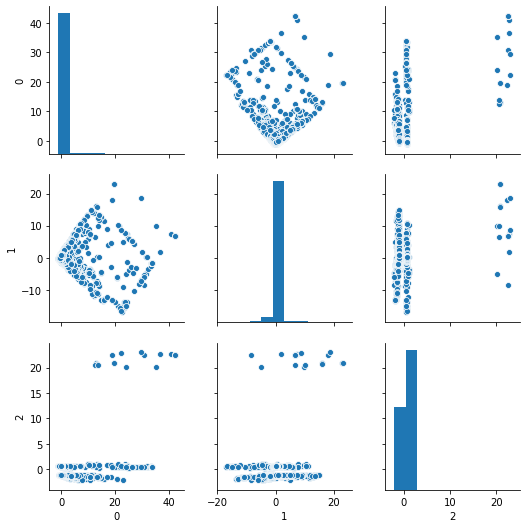

In [4]:
from seaborn import pairplot
%matplotlib inline
pairplot(pd.DataFrame(X_score_reduced))

## 2. Clustering to find representative sample of the data

#### By taking a sample of each cluster of pairs, we have a representative subset of the whole data set
Since we have many possibles pairs (n_rows_source * n_rows_target), we must take a representative subset of all possible pairs in order to train the model. Based on the score matrix defined at the end of the preprocessing pipeline, we can do that using clustering. We cluster the pairs according to their similarity scores.

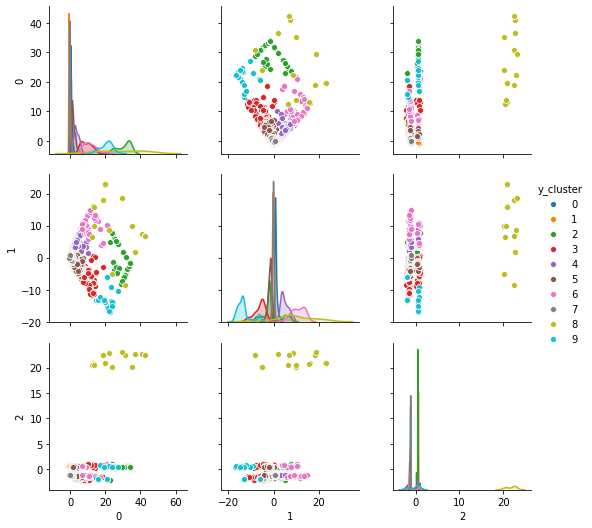

In [5]:
from sklearn.cluster import KMeans
y_cluster = KMeans(n_clusters=10).fit_predict(X_score_reduced)
X_cluster = pd.DataFrame(X_score_reduced)
X_cluster['y_cluster']= y_cluster.astype(str)
pairplot(X_cluster, hue='y_cluster', vars=[0,1,2])

## 3. Asking Representative questions

Now we can take a representative sample of each cluster, and give them to the user to be labelled.

In [6]:
from suricate.explore import SimpleQuestions
from suricate.preutils import createmultiindex
simplequestions = SimpleQuestions(n_questions=8)
y_cluster = pd.Series(data=y_cluster, index=createmultiindex(X=Xst))

In [7]:
ix_questions =  simplequestions.fit_transform(X=y_cluster)
# The code below transforms the array of pairs of ix_questions into a pandas MultiIndex
ix_questions = pd.DataFrame(ix_questions, columns=['ix_source', 'ix_target']).set_index(['ix_source', 'ix_target']).index

ValueError: Shape of passed values is (80, 1), indices imply (80, 2)

In [ ]:
from suricate.dftransformers.cartesian import cartesian_join
X_sbs = cartesian_join(source=source, target = target).set_index(['ix_source', 'ix_target'])
X_sbs.sample(5)

The data can be then exported (for example in a csv file), labellized (0 if it is not a match and 1 if it is a match) and reimported as y_true